<a href="https://colab.research.google.com/github/Alx-Lebeau/Cours-EcoElec/blob/main/notebooks/02_Equilibre_Long_Terme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf Cours-EcoElec
!git clone https://github.com/Alx-Lebeau/Cours-EcoElec.git
%cd Cours-EcoElec/notebooks
!ls


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp as pl
import config


Cloning into 'Cours-EcoElec'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 152 (delta 62), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 2.07 MiB | 7.99 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/Cours-EcoElec/notebooks
01_Equilibre_Court_Terme_correction.ipynb  config.py
01_Equilibre_Court_Terme_énoncé.ipynb	   Consommation_France_2024.csv
02_Equilibre_Long_Terme.ipynb		   Disponibilites_2024.csv


# Méthode des screening curves

In [3]:
# Import des données
df_conso = pd.read_csv("Consommation_France_2024.csv",index_col=0)
df_conso["heure"] = pd.to_datetime(df_conso["heure"])


# Import des données
df_dispo = pd.read_csv("Disponibilites_2024.csv",index_col=0)
df_dispo["heure"] = pd.to_datetime(df_dispo["heure"])

In [ ]:
df_dispo.mean()

,0
heure,2024-07-02 00:04:25.573770240
solaire,0.14
eolien,0.25
nucleaire,0.8
hydraulique,1.0
gaz,0.9
imports,1.0


**Traçage de la monotone :**

Text(0.5, 0, "Nombre d'heure")

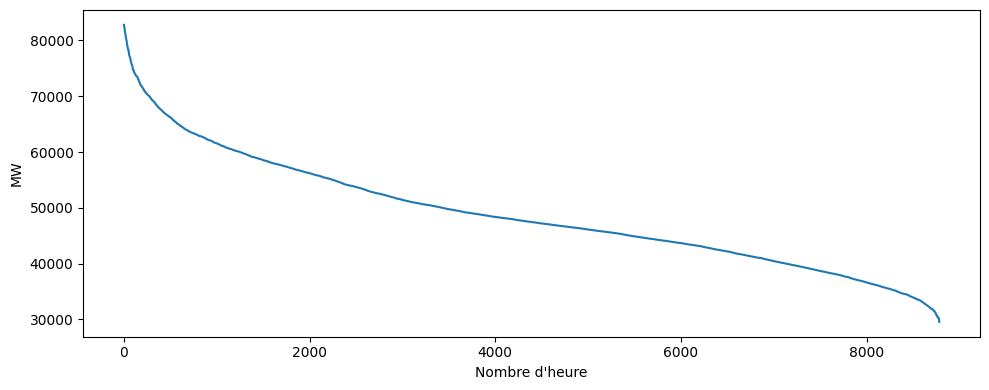

In [ ]:


# Visualisation de l'évolution annuelle de la consommation réalisée

fig, ax = plt.subplots(tight_layout=True,figsize =(10,4))

monotone = df["Consommation réalisée (MW)"].sort_values(ascending=False).values

ax.plot(monotone)

ax.set_ylabel("MW")
ax.set_xlabel("Nombre d'heure")


On considère les deux filières suivantes (données illustratives) :

In [ ]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000}
}

VOLL = 33000 # €/MWh

On trace les courbes de coût total :

(0.0, 500.0)

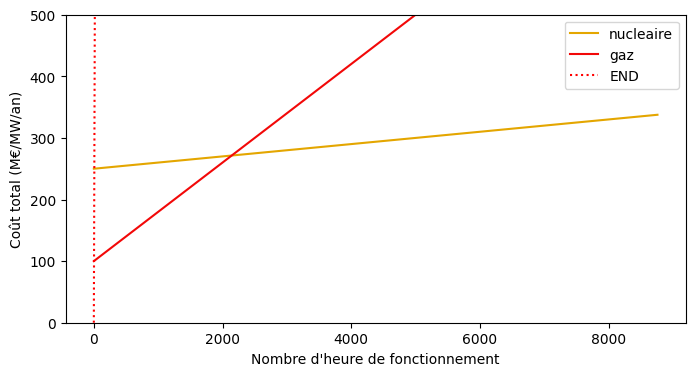

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

t = np.arange(8760)

for i in donnees_filieres :

  dispo_moyenne = df_dispo.mean()[i]

  cost_curve = (donnees_filieres[i]["cout_fixe"] /dispo_moyenne) + donnees_filieres[i]["cout_variable"]*t
  ax.plot(cost_curve / 1000,
          label = i,
          color = config.couleurs[i])

END_curve = VOLL * t

ax.plot(END_curve / 1000,
        label ="END",
        color ="red",
        ls=":")

ax.set_xlabel("Nombre d'heure de fonctionnement")
ax.set_ylabel("Coût total (M€/MW/an)")

ax.legend(loc="best")
ax.set_ylim([0,500])
# ax.set_xlim([0,100]) # à décommenter pour faire un zoom

Les durées d'équilibres entre deux filières $1$ et $2$ sont déterminées par :

$D_{1/2} = \frac{CF_1-CF_2}{CV_2-CV_1}$

On obtient donc ici une durée d'équilibre de 2143 heures entre gaz et nucléaire (= le nucléaire est compétitif devant le gaz s'il produit plus de 2143 heures) et de 3 heures entre le gaz et la défaillance.

In [ ]:
capa_nuc = monotone[2143]
capa_total = monotone[3]
capa_gaz = capa_total - capa_nuc

print(capa_nuc, capa_gaz, capa_total)

55503.0 26979.0 82482.0


# Méthode optim

In [ ]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000}
}

In [ ]:
demande = df["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END + cout d'investissement
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte de capacité


for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )



# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))
print("\t dont coût de production :", pl.value(cout_production))
print("\t dont coût de l'investissement :", pl.value(cout_invest))
print("\t dont coût de l'END :", pl.value(cout_END))


df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = pd.DataFrame(
    {i: df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"] for i in filieres}
).mul(
    df_resultats_horaires[[f"prod_{i}" for i in filieres]].set_axis(filieres, axis=1)
).sum()

df_annuel["rente_inframarginale_EUR_par_MW"] = df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]


Statut : Optimal
Coût total : 21950420763.6
	 dont coût de production : 5361317763.6
	 dont coût de l'investissement : 16574550000.0
	 dont coût de l'END : 14553000.0


In [ ]:
df_capa

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,,
nucleaire,69386.25,55509.0,200000.0,1.387725e+10,200000.0
gaz,29970.00,26973.0,90000.0,2.697300e+09,90000.0


# Avec les EnR

In [ ]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 400000.0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000}
}

In [ ]:
demande = df["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest


for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )


for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )



# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))
print("\t dont coût de production :", pl.value(cout_production))
print("\t dont coût de l'investissement :", pl.value(cout_invest))
print("\t dont coût de l'END :", pl.value(cout_END))


df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_capa = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_capa["rente_inframarginale_EUR"] = pd.DataFrame(
    {i: df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"] for i in filieres}
).mul(
    df_resultats_horaires[[f"prod_{i}" for i in filieres]].set_axis(filieres, axis=1)
).sum()

df_capa["rente_inframarginale_EUR_par_MW"] = df_capa["rente_inframarginale_EUR"] / df_capa["capa_opt_MW"]


Statut : Optimal
Coût total : 32949982691.614716
	 dont coût de production : 7329763858.130716
	 dont coût de l'investissement : 25604148554.6
	 dont coût de l'END : 16070278.884000001


In [ ]:
df_capa

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,,
nucleaire,35841.9430,28673.554400,400000.0,1.433678e+10,400000.008370
gaz,51624.4980,46462.048200,90000.0,4.646205e+09,89999.999613
solaire,9396.1107,1315.455498,78000.0,7.328966e+08,78000.000229
eolien,58882.6990,14720.674750,100000.0,5.888270e+09,100000.000805


Avec contraintes de gisements

In [ ]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0,
                  "capa_max":50000},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000,
            "capa_max":np.inf},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000,
                  "capa_max":np.inf},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000,
                  "capa_max":np.inf}
}

In [ ]:
demande = df["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte Pmax

for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )

# contrainte gisement

for i in filieres :
  if donnees_filieres[i]["capa_max"] != np.inf :
    modele += (
        capa[i] <= donnees_filieres[i]["capa_max"],
        f"capa_max_{i}"
    )


# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))
print("\t dont coût de production :", pl.value(cout_production))
print("\t dont coût de l'investissement :", pl.value(cout_invest))
print("\t dont coût de l'END :", pl.value(cout_END))


df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = pd.DataFrame(
    {i: df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"] for i in filieres}
).mul(
    df_resultats_horaires[[f"prod_{i}" for i in filieres]].set_axis(filieres, axis=1)
).sum()

df_annuel["rente_inframarginale_EUR_par_MW"] = df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]


Statut : Optimal
Coût total : 23331711237.537727
	 dont coût de production : 6510253368.557728
	 dont coût de l'investissement : 16793431660.0
	 dont coût de l'END : 28026208.98


In [ ]:
df_capa

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,,
nucleaire,50000.000,40000.0000,200000.0,1.694923e+10,338984.548909
gaz,43259.854,38933.8686,90000.0,3.893387e+09,89999.998613
solaire,0.000,0.0000,78000.0,0.000000e+00,NaN
eolien,29000.448,7250.1120,100000.0,2.900045e+09,100000.001025


Avec niveau imposé

In [ ]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0,
                  "imposition_capacite":np.nan},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000,
            "imposition_capacite":np.nan},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000,
                  "imposition_capacite":20000},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000,
                  "imposition_capacite":np.nan}
}

In [ ]:
demande = df["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * donnees_filieres[i]["cout_variable"]
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte Pmax

for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )

# imposition capacité

for i in filieres :
  if not pd.isna(donnees_filieres[i]["imposition_capacite"]) :
    modele += (
        capa[i] == donnees_filieres[i]["imposition_capacite"],
        f"imposition_capacite_{i}"
    )

# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))
print("\t dont coût de production :", pl.value(cout_production))
print("\t dont coût de l'investissement :", pl.value(cout_invest))
print("\t dont coût de l'END :", pl.value(cout_END))


df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value() for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = pd.DataFrame(
    {i: df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"] for i in filieres}
).mul(
    df_resultats_horaires[[f"prod_{i}" for i in filieres]].set_axis(filieres, axis=1)
).sum()

df_annuel["rente_inframarginale_EUR_par_MW"] = df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]

Statut : Optimal
Coût total : 22994155145.66242
	 dont coût de production : 5154733011.512417
	 dont coût de l'investissement : 17800025000.0
	 dont coût de l'END : 39397134.15


In [ ]:
df_annuel

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW
filiere,,,,,
nucleaire,66981.25,53585.00,200000.0,1.339625e+10,200000.000000
gaz,31597.50,28437.75,90000.0,2.843775e+09,90000.000000
solaire,20000.00,2800.00,78000.0,4.486564e+08,22432.821307
eolien,0.00,0.00,100000.0,0.000000e+00,NaN


# avec prix CO2

In [ ]:
donnees_filieres = {
    "nucleaire": {"cout_variable": 10.0,
                  "cout_fixe": 200000.0,
                  "capa_max":50000,
                  "facteur_emission":0},
    "gaz": {"cout_variable": 80.0,
            "cout_fixe": 90000,
            "capa_max":np.inf,
            "facteur_emission":0.4},
    "solaire": {"cout_variable": 0.0,
                 "cout_fixe":78000,
                  "capa_max":np.inf,
                  "facteur_emission":0},
    "eolien": {"cout_variable": 0.0,
                 "cout_fixe":100000,
                  "capa_max":np.inf,
                  "facteur_emission":0}
}

In [ ]:
demande = df["Consommation réalisée (MW)"].values

VOLL = 33000.0  # €/MWh

prix_CO2 = 300

# ---- Ensembles ----
filieres = list(donnees_filieres.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)


# ---- Variables de décision ----
# prod[i, t] = production de la filière i au temps t (MW)
prod = pl.LpVariable.dicts("prod", (filieres, T), lowBound=0)

# capacités
capa = pl.LpVariable.dicts("capa",(filieres),lowBound=0)


# END[t] = énergie non distribuée au temps t (MW)
END = pl.LpVariable.dicts("END", T, lowBound=0)

# ---- Objectif : minimiser le coût total ----

# 1) coût des filières de production
cout_production = pl.lpSum(
    prod[i][t] * (donnees_filieres[i]["cout_variable"] + donnees_filieres[i]["facteur_emission"] * prix_CO2)
    for i in filieres
    for t in T
)


# 2) coût de l'énergie non distribuée
cout_END = pl.lpSum(
    END[t] * VOLL
    for t in T
)

# 3) coût d'investissement

cout_invest = pl.lpSum(
    capa[i] * donnees_filieres[i]["cout_fixe"]
    for i in filieres
)

# Objectif total = production + END
modele += cout_production + cout_END + cout_invest

# contrainte EOD

for t in T:
    modele += (
        pl.lpSum(prod[i][t] for i in filieres) + END[t] == demande[t],
        f"Equilibre_t{t}"
    )

# contrainte Pmax

for i in filieres:
    for t in T:
        modele += (
            prod[i][t] <= capa[i] * df_dispo.loc[t][i],
            f"Capacite_{i}_t{t}"
        )

# contrainte gisement

for i in filieres :
  if donnees_filieres[i]["capa_max"] != np.inf :
    modele += (
        capa[i] <= donnees_filieres[i]["capa_max"],
        f"capa_max_{i}"
    )


# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective) / 1e9)
print("\t dont coût de production (Md€) :", pl.value(cout_production) / 1e9)
print("\t dont coût de l'investissement (Md€) :", pl.value(cout_invest)/ 1e9)
print("\t dont coût de l'END (Md€) :", pl.value(cout_END)/ 1e9)


df_resultats_horaires = pd.DataFrame({
    "demande": demande,
    "END": [END[t].value() for t in T],
    "prix_marginal": [
        modele.constraints[f"Equilibre_t{t}"].pi for t in T
    ],
    **{
        f"prod_{i}": [prod[i][t].value() for t in T]
        for i in filieres
    }
})


df_annuel = pd.DataFrame({
    "filiere": filieres,
    "capa_opt_MW": [capa[i].value()  for i in filieres],
    "capa_dispo_MW": [capa[i].value() * df_dispo.mean()[i] for i in filieres],
    "cout_fixe_EUR_par_MW": [donnees_filieres[i]["cout_fixe"] for i in filieres],
}).set_index("filiere")

# calcul des rentes inframarginales :


# Rentes inframarginales (EUR) sur l'horizon + par MW installé (EUR/MW)
df_annuel["rente_inframarginale_EUR"] = pd.DataFrame(
    {i: df_resultats_horaires["prix_marginal"] - donnees_filieres[i]["cout_variable"] - donnees_filieres[i]["facteur_emission"] * prix_CO2 for i in filieres}
).mul(
    df_resultats_horaires[[f"prod_{i}" for i in filieres]].set_axis(filieres, axis=1)
).sum()

df_annuel["rente_inframarginale_EUR_par_MW"] = df_annuel["rente_inframarginale_EUR"] / df_annuel["capa_opt_MW"]


df_annuel["emissions_tCO2"] = {
    i: (df_resultats_horaires[f"prod_{i}"] * donnees_filieres[i]["facteur_emission"]).sum() / 1e6
    for i in filieres
}



Statut : Optimal
Coût total : 26.628961514756902
	 dont coût de production (Md€) : 6.795651628344902
	 dont coût de l'investissement (Md€) : 19.816233476599997
	 dont coût de l'END (Md€) : 0.017076409812


In [ ]:
df_annuel

,capa_opt_MW,capa_dispo_MW,cout_fixe_EUR_par_MW,rente_inframarginale_EUR,rente_inframarginale_EUR_par_MW,emissions_tCO2
filiere,,,,,,
nucleaire,50000.0000,40000.000000,200000.0,2.190141e+10,438028.161864,0.000000
gaz,39445.3480,35500.813200,90000.0,3.550081e+09,89999.999493,8.069421
solaire,8538.2097,1195.349358,78000.0,6.659804e+08,77999.999928,0.000000
eolien,56001.7180,14000.429500,100000.0,5.600172e+09,100000.000078,0.000000
